In [42]:
%load_ext autoreload
%autoreload 2

# Import Modules

In [4]:
import Labber
import numpy as np
import os
import matplotlib.pyplot as plt
from fitTools.Resonator import Resonator
import logging

0.7940375098915251 0.9999048251485131


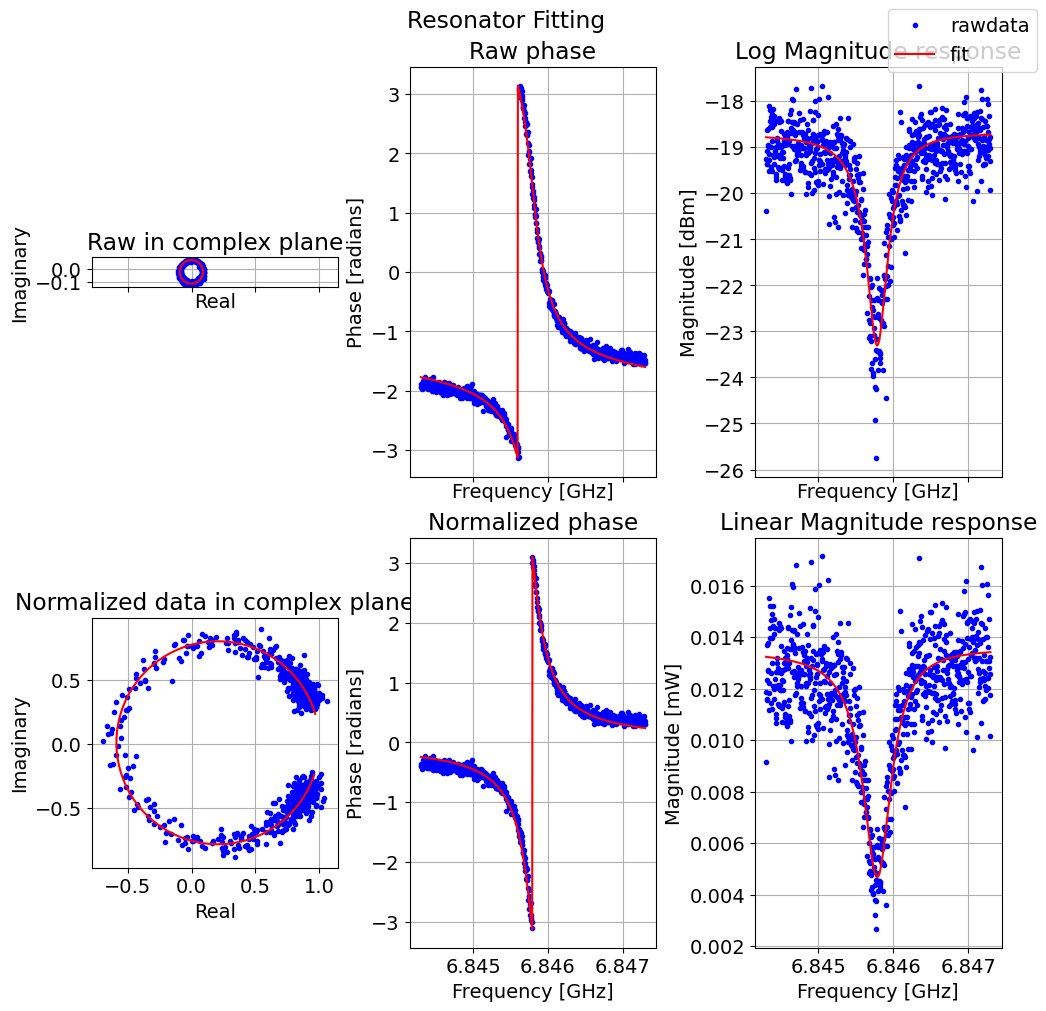


Fit at V dBm
Frequency: 6.8458 GHz
Total Q: 14916
Internal Q: -25371
Coupling Q: 9394
FWHM: 0.45894 MHz
Kappa: 2.88361 MHz
Single Photon Power: -146.9 dBm
Ringdown Time: 0.481 us
Impedance Mismatch -0.791 degrees
Electrical Delay: 16.566495 ns
SNR: 97660.4

Q_ext = [9393.70376673757], Q_int = [-25371.45899410408], Q_tot = [14916.486485681737]


<Figure size 900x600 with 0 Axes>

In [43]:
res_idx = 1
directory = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430'
# directory = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5'
chip_name = 'highQ-resonators-round3-chipA-'
res = f'res{res_idx}'
suffix = '-40db-atten.hdf5'
fpath = os.path.join(directory,chip_name+res+suffix)
# fpath = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5'
fpath = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\05\Data_0501\highQ-resonators-round3-chipA-res1-40db-atten.hdf5'
#G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5
# fpath = r'G:\Shared drives\Labber\Data\2024\04\Data_0426\highQ-resonators-round3-chipA-res1-40db-atten.hdf5'
fit_resonator(fpath,res_type="n")
# convert_data_to_csv(fpath, save_header=False)

# Power Sweep

In [ ]:
res_idx = 5
res = f'res{res_idx}'
suffix = '-power-sweep.hdf5'
fpath = os.path.join(directory,chip_name+res+suffix)
fit_resonator(fpath,res_type="n")

# Functions

## Fit single resonator

In [1]:
def load_datafile(filepath):
    '''Load Labber data file and create a log file for logging information'''
    path,fname = os.path.split(fpath)
    path += r'\\'
    figpath = 'figures\\'+fname[:-4]+'\\'
    if not os.path.exists(path+'figures\\'):
        os.mkdir(path+'figures\\')
    if not os.path.exists(path+figpath):
        os.mkdir(path+figpath)
    lf = Labber.LogFile(path + fname)

    logFileName = path + f"profile_info_{fname[:-4]}log"
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger()
    logger.addHandler(logging.FileHandler(logFileName, 'a'))
    print = logger.info

    return lf

In [39]:
def fit_resonator(fpath:str,res_type:str = "n"):
    plt.rcParams.update({'font.size':14})

    # fpath = input("Path to .hdf5 file: ").replace('"','')
    # res_type = input("What is the resonator type? [\"n\" for notch, \"r\" for reflection, and \"t\" for transmission]: \n")
    if res_type not in ["r","t","n"]:
        res_type = "n"
        print("Notch type resonator used by default")
    
    lf = load_datafile(fpath)

    nEntries = lf.getNumberOfEntries()
    pow_offset = 40 # Attens after VNA 
    power = lf.getStepChannels()[0]["name"]

   # a = 0
   # b = 0

    fits = {'f':[],'Q':[],'Qint':[],'Qext':[]}
    for n in range(nEntries):
        (xdata,ydata) = lf.getTraceXY(entry = n)
        res = Resonator(res_type, xdata,ydata)
        
        # try:
        res.autofit()
        # except:
        # fstart = input("Enter start frequency for fit in GHz: ")
        # fstop = input("Enter stop frequency for fit in GHz: ")
        # res.autofit(fcrop=(fstart,fstop))
        fits['f'].append(res.f0*1e-9)
        fits['Q'].append(res.Q)
        fits['Qint'].append(res.Qi)
        fits['Qext'].append(res.Qc)

        if res.fit_found:
            print(20*"=")
            # res.show(savefile = path+figpath+fname[:-4]+'resonance_{}-dBm.png'.format(power[n]))
            res.show()
            print('\nFit at {} dBm'.format(power[n]))
            print(res)
            print(20*"="+"\n")


    fig = plt.figure(figsize=[9,6],constrained_layout=True)
    
    print(f"Q_ext = {fits['Qext']}, Q_int = {fits['Qint']}, Q_tot = {fits['Q']}")
    # print(f"\n\nLog File: {logFileName}")
    # print(f"\nPlots Directory: {path + figpath}")

In [30]:
import pandas as pd

def convert_data_to_csv(filepath, save_header=False):
    lf = load_datafile(filepath)
    
    (freqs, zdata) = lf.getTraceXY(entry = 0)
    phases =  np.unwrap(np.angle(zdata))
    
    # Create a DataFrame with xdata and ydata
    df = pd.DataFrame({'freqs': freqs, 'amps': abs(zdata), 'phases': 180/np.pi*phases})
    
    # Get the file name without extension
    file_name = os.path.splitext(filepath)[0]
    
    # Strip the .hdf5 ending from the file_name
    file_name = file_name.rstrip('.hdf5')
    
    # Save the DataFrame to a CSV file
    csv_file = file_name + '.csv'
    plt.plot(freqs,np.abs(zdata))
    df.to_csv(csv_file, header=save_header, index=False)
    
    return csv_file
    


## Fit power sweep data

In [ ]:
def fit_power_sweep(fpath):
    res_type = 'n'
    # extract data from Labber file
    lf = Labber.LogFile(fpath)